# Basic Usage of the `tyssue` library

## Easy creation of a 2D epithelial sheet

In [1]:
%matplotlib inline

# Core object
from tyssue import Sheet
# Simple 2D geometry
from tyssue import PlanarGeometry
# Visualisation
from tyssue.draw import sheet_view

sheet = Sheet.planar_sheet_2d('basic2D', nx=6, ny=7,
                              distx=1, disty=1)
PlanarGeometry.update_all(sheet)
sheet.sanitize()


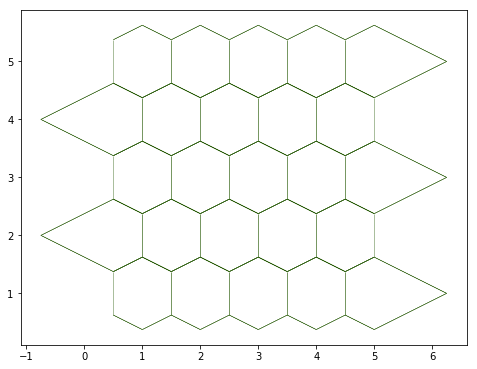

In [4]:
fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

### A remark on the half-edge data structure


As is represented in the above graph, each edge between two cells is composed of two half-edges (only one half-edge is present in the border ones). This makes it easier to compute many cell-specific quantities, as well as keeping a well oriented mesh. This is inspired by CGAL [polyhedral surfaces](https://doc.cgal.org/4.2/CGAL.CGAL.3D-Polyhedral-Surface/html/index.html).

## Datasets and specifications


The data associated with the mesh displayed above, i.e. the points positions,
the connectivity information, etc. is stored in pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) objects, hold together in the `datasets` dictionnary.


Depending on the geometry, the following dataframes are populated:
* `datasets["edge"]` or `sheet.edge_df`: The edge related dataframe contains 
 - the connectivity information: source and target vertices, associated face and (for thick tissues)
   the associated cell body.
 - geometry data associated with the edge, such as its length
 - any suplemental data, such as a color or a dynamical parameter (an elasticity for example)

* `datasets["vert"]` or `sheet.vert_df`: The vertices related dataframe. In the apical junction mesh above, 
  those are  the vertices at the cells junctions. It usually holds the coordinates of the points, 
  and geometry or dynamical data.

* `datasets["face"]` or `sheet.face_df`: The faces related dataframe. For a thin, 2D tissue, this corresponds to
  a cell of the epithelium, delimited by its edges. In thick, 3D models, one cell has several faces
  (the apical, sagittal and basal ones for a 3D monolayer, for example).
 
* `datasets["cell"]` or `sheet.cell_df`: The cells related dataframe, only for 3D, thick, epithelium.
  Each cell have several faces.
  
  
  ![datastructures in `tyssue`](../illus/tyssue_data_management.png)
 

In [5]:
for element, data in sheet.datasets.items():
    print(element, ':', data.shape)

vert : (65, 3)
edge : (145, 17)
face : (25, 6)


In [6]:
sheet.datasets['edge'].head()

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,ty,fx,fy,ux,uy,sub_area,is_valid
edge,,,,,,,,,,,,,,,,,
0,2,0.7500,1.397542,15,5,-1.25,-0.625,0.5,4.625,-0.75,4.000,0.45,4.0,0.0,0.0,0.37500,True
1,5,0.3750,0.750000,20,4,0.00,-0.750,0.5,5.375,0.50,4.625,1.00,5.0,0.0,0.0,0.18750,True
2,6,0.4125,0.750000,15,0,0.00,0.750,1.0,3.625,1.00,4.375,0.45,4.0,0.0,0.0,0.20625,True
3,0,0.3750,0.750000,16,6,0.00,-0.750,1.0,4.375,1.00,3.625,1.50,4.0,0.0,0.0,0.18750,True
4,3,0.3125,0.559017,10,0,-0.50,-0.250,1.0,3.625,0.50,3.375,1.00,3.0,0.0,0.0,0.15625,True


In [7]:
sheet.face_df.head()

,y,is_alive,perimeter,area,x,num_sides
face,,,,,,
0,1.0,1,3.736068,1.00000,1.00,6
1,1.0,1,3.736068,1.00000,2.00,6
2,1.0,1,3.736068,1.00000,3.00,6
3,1.0,1,3.736068,1.00000,4.00,6
4,1.0,1,4.663119,1.28125,5.05,5


We can use all the goodies from pandas DataFrames objects. For example, it is possible to 
compute the average edge length for each face like so:

In [8]:
sheet.edge_df.groupby('face')['length'].mean().head()

face
0    0.622678
1    0.622678
2    0.622678
3    0.622678
4    0.932624
Name: length, dtype: float64

**Specifications** are defined as a nested dictionnary, `sheet.specs`. For each element, the specification defines the columns of the corresonding DataFrame and their default values. An extra key at the root of the specification is called `"settings"`, and can hold specific parameters, for example the arguments for an energy minimization procedure.

In [9]:
sheet.specs

{'edge': {'trgt': 0,
  'nz': 0.0,
  'length': 1.0,
  'face': 0,
  'srce': 0,
  'dx': 0.0,
  'dy': 0.0,
  'sx': 0.0,
  'sy': 0.0,
  'tx': 0.0,
  'ty': 0.0,
  'fx': 0.0,
  'fy': 0.0,
  'ux': 0.0,
  'uy': 0.0},
 'vert': {'y': 0.0, 'is_active': 1, 'x': 0.0},
 'face': {'y': 0.0,
  'is_alive': 1,
  'perimeter': 0.0,
  'area': 0.0,
  'x': 0.0,
  'num_sides': 6},
 'settings': {'geometry': 'planar'}}

It is possible to update dynamically the data structure. For example, let's assume we want to put quasi-static model to minimize energy for the tyssue. For this we need three things.
* A specification dictionnary with the required data
* A model
* A solver

Successfull gradient descent?  True


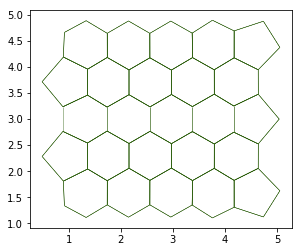

In [10]:
from tyssue.config.dynamics import quasistatic_plane_spec
from tyssue.dynamics.planar_vertex_model import PlanarModel
from tyssue.solvers import QSSolver

# Update the specs
sheet.update_specs(quasistatic_plane_spec())

# Find energy minimum
solver = QSSolver()
res = solver.find_energy_min(sheet, 
                             PlanarGeometry,
                             PlanarModel)

print("Successfull gradient descent? ", res['success'])
fig, ax = sheet_view(sheet)

## Upcasting and downcasting data


### Upcasting

Geometry or physics computations often require to access for example
the cell related data on each of the cell's edges. The `Epithelium`
class and its derivatives defines utilities to make this,
i.e copying the area of each face to each of its edges:

In [11]:
print('Faces associated with the first edges:')
print(sheet.edge_df['face'].head())
print('\n')

# First edge associated face
face = sheet.edge_df.loc[0, 'face']

print('Area of cell # {}:'.format(int(face)))
print(sheet.face_df.loc[face, 'area'])

print('\n')
print('Upcasted areas over the edges:')
print(sheet.upcast_face(sheet.face_df['area']).head())

Faces associated with the first edges:
edge
0    15
1    20
2    15
3    16
4    10
Name: face, dtype: int64


Area of cell # 15:
0.5334928523483278


Upcasted areas over the edges:
edge
0    0.533493
1    0.581727
2    0.533493
3    0.572036
4    0.588162
Name: area, dtype: float64


The values have indeed be upcasted. This can also be done with the source and target vertices 
(`sheet.upcast_srce`, `sheet.upcast_trgt`) and cells in the 3D case (`sheet.upcast_cell`).

### Downcasting

This is usually done by `groupby` operations as shown above.
Syntactic sugar is available for summation, e.g. over every edges with a given source: 

In [12]:
sheet.sum_srce(sheet.edge_df['line_tension']).head()

,line_tension
srce,
0,0.36
1,0.12
2,0.12
3,0.24
4,0.12


## Input and Output

The 'native' format is to save the datasets to hdf5 via [`pandas.HDFStore`](https://pandas.pydata.org/pandas-docs/stable/cookbook.html#hdfstore). The `io.obj` also provides functions to export the junction mesh or triangulations to the wavefront `OBJ` format (requires `vispy`), for easy import in 3D software such as Blender.

Here is the code to save the data in wavefront `OBJ`:
```python
obj.save_junction_mesh('junctions.obj', sheet)
```

The standard data format for the datasets is HDF:

In [13]:
from tyssue.io import hdf5

#### Writing

In [14]:
hdf5.save_datasets('tmp_data.hdf5', sheet)


#### Reading

In [15]:
dsets = hdf5.load_datasets('tmp_data.hdf5')
sheet2 = Sheet('reloaded', dsets)

In [16]:
!rm tmp_data.hdf5

Specs can be saved as json files:

In [17]:
import json

with open("tmp_specs.json", "w") as jh:
    json.dump(sheet.specs, jh)

And reloaded accordingly

In [18]:
with open("tmp_specs.json", "r") as jh:
    specs = json.load(jh)

sheet2.update_specs(specs, reset=False)

In [19]:
!rm tmp_specs.json